In [316]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [10]:
import forecastio
import datetime
import pandas as pd
import numpy as np
import time
import datetime
import pytz
import httplib
import json
from time import mktime
from pprint import pprint
from datetime import date
from datetime import datetime


# 1. Cleaning Crime Data For Creation of Dynamic Datasets 

As noted in various sections, Boston crime incident data from 07/08/2012 to 8/10/2015 is the central dataset used in this project. As shown below, the dataset provides intricate detail on each incident of crime. The most important columns of the dataset are "FROMDATE" (which provides the time and date of the crime), "Location" (which provides the latitude and longitude of the crime), and "INCIDENT_TYPE_DESCRIPTION" and "MAIN_CRIMECODE" (which both identify the type of crime that occured). 



This dataset was originally found here: https://data.cityofboston.gov/Public-Safety/Crime-Incident-Reports/7cdf-6fgx. Some data cleaning was completed in a different section of the project (**get from Wilder what was done before this**), and that work is read in below for further cleaning. 

In [731]:
#read in the cleaning work that has already been done
dftouse=pd.read_csv("/Users/James/Dropbox/CS109 Final Project/Crime_Incident_Reports_somewhatcleaned.csv")

In [721]:
#show the first 5 rows in the cleaning work
dftouse.head(5)

,COMPNOS,NatureCode,INCIDENT_TYPE_DESCRIPTION,MAIN_CRIMECODE,REPTDISTRICT,REPORTINGAREA,FROMDATE,WEAPONTYPE,Shooting,DOMESTIC,SHIFT,Year,Month,DAY_WEEK,UCRPART,X,Y,STREETNAME,XSTREETNAME,Location
0,120420285,BERPTA,RESIDENTIAL BURGLARY,05RB,D4,629,07/08/2012 06:00:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,763273.1791,2951498.962,ABERDEEN ST,NaN,"(42.34638135, -71.10379454)"
1,120419202,PSHOT,AGGRAVATED ASSAULT,04xx,B2,327,07/08/2012 06:03:00 AM,Firearm,Yes,No,Last,2012,7,Sunday,Part One,771223.1638,2940772.099,HOWARD AV,NaN,"(42.31684135, -71.07458456)"
2,120419213,ARMROB,ROBBERY,03xx,D4,625,07/08/2012 06:26:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,765118.8605,2950217.536,JERSEY ST,QUEENSBERRY ST,"(42.34284135, -71.09698955)"
3,120419223,ALARMC,COMMERCIAL BURGLARY,05CB,B2,258,07/08/2012 06:56:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,773591.8648,2940638.174,COLUMBIA RD,NaN,"(42.3164411, -71.06582908)"
4,120419236,ARMROB,ROBBERY,03xx,E18,496,07/08/2012 07:15:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,759042.7315,2923832.681,COLLINS ST,NaN,"(42.27051636, -71.11989955)"


   The first step in continuing to clean the crime incident dataset focuses on the "FROMDATE" column, which indicates the time at which the crime occured. Currently, the values are all strings. Below, these values are converted into both datetime values as well as epoch values. These datetime and epoch values are used in the API calls below as well as in all of our models. 


   It is important to note that the "FROMDATE" values are accurate to the minute. However, for this project, we are interested in values with hour granularity. This is because all of the dynamic data acquired for this project is listed by the hour. As a result, below we also truncate/round-down the epoch and datetime values so that they each reflect an on-the-hour time. 

   Both the truncated and the non-truncated values are stored in the time_df dataframe (and the time_dfs dataframe, which is the sorted version of time_df).
    


In [38]:
from time import mktime
from datetime import datetime
epoch_times = []
datetime_times = []
dt_truncated = []
epoch_times_truncated = []

for i in dftouse['FROMDATE'].values:
    new_time = time.strptime(i, "%m/%d/%Y %H:%M:%S %p") 
    #convert to epoch
    epoch_i = mktime(new_time)
    epoch_times.append(epoch_i)
    #convert to datetime
    datetime_i = datetime.fromtimestamp(epoch_i)
    datetime_times.append(datetime_i)
    #truncate/round down datetime
    dt_truncated_i = datetime_i.replace(minute=0, second=0, microsecond=0)
    dt_truncated.append(dt_truncated_i)
    dtnew_time = time.strptime(dt_truncated_i.strftime('%m/%d/%Y %H:%M:%S %p'),  "%m/%d/%Y %H:%M:%S %p") 
    #truncate/round down epoch
    epoch_truncated = mktime(dtnew_time)
    epoch_times_truncated.append(epoch_truncated)

Even after adjusting the granularity of the time from minute to hour, we are left with 12,934 unique times at which crimes occur (shown in the output of the cell below). Of course, multiple crimes can occur at the same hour in different locations. As we will show later on, incorporating the location as well as the time of the crime is a more accurate representation of the number of unique crimes we are able to examine.

In [282]:
myset = set(dt_truncated)
truncated_unique = list(myset)
print "unique times (to the hour) in which crimes occur:", len(truncated_unique)

unique times (to the hour) in which crimes occur: 12934


The second step in continuing to clean the crime incident dataset focuses on the "Location" column, which specifies that latitude and longitude at which a given crime occured. Currently, the "Location" values are just strings. Below, each location string is split into a latitude value and a longitude value. These values are then converted to floats, as they are meant to represent numeric values. 

The latitude values and longitude values are each stored in different columns in the time_df dataframe (and the time_dfs dataframe, which is the sorted version of time_df). 

In [41]:
lat_values = []
long_values = []
for i in dftouse['Location'].values:
    #split string, remove excess characters, and convert to float.
    split_ll = [x.strip() for x in i.split(',')]
    lat = split_ll[0].replace('(', '').replace(')', '')
    long = split_ll[1].replace('(', '').replace(')', '')
    lat_values.append(float(lat))
    long_values.append(float(long))

As mentioned above, we take these new time and location values and store them in a dataframe called time_df. We then sort the time_df dataframe chronlogically by "DATETIME_TRUNC" and store this sorted dataframe as time_dfs.

In [42]:
s1 = pd.Series(epoch_times, name='EPOCH')
s2 = pd.Series(datetime_times, name='DATETIME')
s3 = pd.Series(dt_truncated, name='DATETIME_TRUNC')
s4 = pd.Series(lat_values, name='LATITUDE')
s5 = pd.Series(long_values, name='LONGITUDE')
s6 = pd.Series(epoch_times_truncated, name='EPOCH_TRUNC')

In [44]:
time_df = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)

In [796]:
time_dfs = time_df.sort(['DATETIME_TRUNC'])
time_dfs.head()

,EPOCH,DATETIME,DATETIME_TRUNC,LATITUDE,LONGITUDE,EPOCH_TRUNC
53,1341725400,2012-07-08 01:30:00,2012-07-08 01:00:00,42.350866,-71.060710,1341723600
48,1341723600,2012-07-08 01:00:00,2012-07-08 01:00:00,42.307541,-71.076090,1341723600
49,1341723600,2012-07-08 01:00:00,2012-07-08 01:00:00,42.284104,-71.046135,1341723600
50,1341723600,2012-07-08 01:00:00,2012-07-08 01:00:00,42.317851,-71.098805,1341723600
51,1341724620,2012-07-08 01:17:00,2012-07-08 01:00:00,42.349201,-71.095445,1341723600


Finally, we concat this time_dfs dataframe with the dataset at the beginning of this section to obtain a newly cleaned Boston crime incident dataset that we call concat_df.

In [740]:
time_df.reset_index()
concat_df = pd.concat([time_df, dftouse], axis=1)
print "The shape of our newly cleaned Boston crime incident dataset (concat_df) is:", concat_df.shape
concat_df.head()

The shape of our newly cleaned Boston crime incident dataset (concat_df) is: (253075, 26)


,EPOCH,DATETIME,DATETIME_TRUNC,LATITUDE,LONGITUDE,EPOCH_TRUNC,COMPNOS,NatureCode,INCIDENT_TYPE_DESCRIPTION,MAIN_CRIMECODE,REPTDISTRICT,REPORTINGAREA,FROMDATE,WEAPONTYPE,Shooting,DOMESTIC,SHIFT,Year,Month,DAY_WEEK,UCRPART,X,Y,STREETNAME,XSTREETNAME,Location
0,1341741600,2012-07-08 06:00:00,2012-07-08 06:00:00,42.346381,-71.103795,1341741600,120420285,BERPTA,RESIDENTIAL BURGLARY,05RB,D4,629,07/08/2012 06:00:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,763273.1791,2951498.962,ABERDEEN ST,NaN,"(42.34638135, -71.10379454)"
1,1341741780,2012-07-08 06:03:00,2012-07-08 06:00:00,42.316841,-71.074585,1341741600,120419202,PSHOT,AGGRAVATED ASSAULT,04xx,B2,327,07/08/2012 06:03:00 AM,Firearm,Yes,No,Last,2012,7,Sunday,Part One,771223.1638,2940772.099,HOWARD AV,NaN,"(42.31684135, -71.07458456)"
2,1341743160,2012-07-08 06:26:00,2012-07-08 06:00:00,42.342841,-71.096990,1341741600,120419213,ARMROB,ROBBERY,03xx,D4,625,07/08/2012 06:26:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,765118.8605,2950217.536,JERSEY ST,QUEENSBERRY ST,"(42.34284135, -71.09698955)"
3,1341744960,2012-07-08 06:56:00,2012-07-08 06:00:00,42.316441,-71.065829,1341741600,120419223,ALARMC,COMMERCIAL BURGLARY,05CB,B2,258,07/08/2012 06:56:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,773591.8648,2940638.174,COLUMBIA RD,NaN,"(42.3164411, -71.06582908)"
4,1341746100,2012-07-08 07:15:00,2012-07-08 07:00:00,42.270516,-71.119900,1341745200,120419236,ARMROB,ROBBERY,03xx,E18,496,07/08/2012 07:15:00 AM,Firearm,No,No,Last,2012,7,Sunday,Part One,759042.7315,2923832.681,COLLINS ST,NaN,"(42.27051636, -71.11989955)"


In [286]:
#store this newly cleaned dataset for future use
concat_df.to_csv("JRcleaningcontinued.csv", index=True)

# 2. Obtaining and Cleaning Dynamic Weather Data

As mentioned in other sections of this project, we hope to use dynamic data and static data to predict how likely a crime is to occur at a given location at a given time. The dynamic features are defined as varying over time. The Boston incident data therefore has one dynamic dataset built in: the time at which the crime occured. 

Below, we obtain and clean data for another dynamic factor: the weather at a given time and location. One can imagine some possible relationships between weather patterns and crimes; perhaps, for example, fewer robberies occur when it is raining and/or cold because fewer people are outside. We used the Dark Sky Forecast API (see https://developer.forecast.io for more information) to gather the required information. This particular API was selected because it provides historical data for the correct time span and the correct granularity (to the hour). As discussed in detail later, finding APIs that provided accesss to historical data, for any type of data (not just weather), proved to be incredibly difficult. A variety of APIs were attempted--including Weather Underground, Yahoo Weather, and Apixu-- but very few provided data for more than 30 days ago. 

The Dark Sky Forecast API is not free to use. However, after contacting Dark Sky and explaining our use of the data, we were able to increase our free call limit. As a result, we did not end up paying much money to use the API.

In [3]:
!pip install python-forecastio

    100% |████████████████████████████████| 499kB 376kB/s 
  Found existing installation: requests 1.1.0
    Uninstalling requests-1.1.0:
      Successfully uninstalled requests-1.1.0


In [48]:
#get all lat-long values from crime dataset
lat_long_values = dftouse["Location"].values

We begin by examining the number of unique locations in Boston at which crimes occured between July 2012 and August 2015:

In [290]:
lat_long_set = set(lat_long_values)
#print myset
lat_long_unique = list(lat_long_set)
print "total number of not unique lat-long pairs (to 8 decimal places) in dataset:" , len(lat_long_values)
print "total number of unique lat-long pairs (to 8 decimal places) in dataset:", len(lat_long_unique)
print "difference:", len(lat_long_values) - len(lat_long_unique)

total number of not unique lat-long pairs (to 8 decimal places) in dataset: 253075
total number of unique lat-long pairs (to 8 decimal places) in dataset: 23198
difference: 229877


Collecting data for the weather at each of these 23,198 unique locations for every hour of interest would yield a dataset of a difficult and cumbersome size. Note that the latitude and longitude values above are reported to 8 decimal places. It is unnecessary to examine this level of granularity, especially because the weather will not be significantly different at many of these finely identified locations.

As a result, below we round our latitude and longitude values to one decimal place. This allows us to produce a weather dataset of managable size:

In [738]:
all_two = []
for i, r in time_df.iterrows():
    lat = float('%.1f'%(r["LATITUDE"]))
    long = float('%.1f'%(r["LONGITUDE"]))
    all_two.append((lat,long))
   

In [293]:
all_two_set = set(all_two) 
all_two_unique = list(all_two_set)
print "total number of not unique lat-long pairs (to 1 decimal place) in dataset:" , len(all_two)
print "total number of unique lat-long pairs (to 1 decimal place) in dataset:", len(all_two_unique)
print "difference:" , len(all_two) - len(all_two_unique)
print "the unique lat-long value pairs are:",all_two_unique

total number of not unique lat-long pairs (to 1 decimal place) in dataset: 253075
total number of unique lat-long pairs (to 1 decimal place) in dataset: 7
difference: 253068
the unique lat-long value pairs are: [(42.2, -71.1), (42.4, -71.2), (42.4, -71.1), (42.4, -71.0), (42.3, -71.0), (42.3, -71.1), (42.3, -71.2)]


We now examine the number of unique times at which crimes occured in Boston between July 2012 and August 2015. While, for now, we are only examining the weather during hours at which crime occured, it is important to note that we will ultimately be gathering the weather data for every hour between July 2012 and August 2015. We collect information on every hour because we also want to understand which weather features are most common amongst times during which crime did not occur. 

In [51]:
every_hour = []
for i, r in time_df.iterrows():
    every_hour.append(r["DATETIME_TRUNC"])

In [291]:
every_hour_set = set(every_hour)
every_hour_unique = list(every_hour_set)
print "total number of not unique hours in dataset: " , len(every_hour)
print "total number of unique hours in the dataset:", len(every_hour_unique)
print "difference" , len(every_hour) - len(every_hour_unique)

total number of not unique hours in dataset:  253075
total number of unique hours in the dataset: 12934
difference 240141


Of course, when using weather data, we really care about the total number of unique lat-long-time triples in the dataset because the weather at a given location changes over time. So, we find that number below:

In [50]:
all_three = []
for i, r in time_df.iterrows():
    lat = float('%.1f'%(r["LATITUDE"]))
    long = float('%.1f'%(r["LONGITUDE"]))
    all_three.append((r["DATETIME_TRUNC"],lat,long))

In [294]:
all_three_set = set(all_three)
all_three_unique = list(all_three_set)
print "total number of not unique lat-long-time triples in dataset:" , len(all_three)
print "total number of unique lat-long-time triples in dataset:", len(all_three_unique)
print "difference:" , len(all_three) - len(all_three_unique)

total number of not unique lat-long-time triples in dataset: 253075
total number of unique lat-long-time triples in dataset: 48961
difference: 204114


So, there are 48,961 lat-long-time triples that we care about. We store these triples in df_all3 and sort it by time:

In [797]:
df_all3 = pd.DataFrame(all_three_unique, columns = ["DATETIME_TRUNC", "LATITUDE", "LONGITUDE"])
df_all3 = df_all3.sort(['DATETIME_TRUNC'])
df_all3.head()

,DATETIME_TRUNC,LATITUDE,LONGITUDE
17440,2012-07-08 01:00:00,42.4,-71.0
40236,2012-07-08 01:00:00,42.3,-71.0
39988,2012-07-08 01:00:00,42.3,-71.1
22199,2012-07-08 01:00:00,42.4,-71.1
31131,2012-07-08 02:00:00,42.3,-71.1


For reasons previously mentioned, we will want to collect the hourly weather for every hour between July 2012 and August 2015. So, below we create a list of all of the day values starting on July 1, 2012 in order to query the Dark Sky Forecast API. We are creating a list of days rather than hours because the Dark Sky Forecast API call below is programmed to return the hourly weather for all 24 hours on the given day that is passed in as an argument.

In [306]:
import datetime
all_dates = []
start = datetime.datetime(2012, 7, 1)
for offset in range(0, 1185): #1550
    all_dates.append(start+datetime.timedelta(offset))

We now use the Dark Sky Forecast API to retrieve the hourly weather information at the 7 unique locations identified above. Note that this step can take a bit of time, roughly 35 minutes on my machine:

In [803]:
%%time
#this code is adapted from: http://nipunbatra.github.io/2015/05/weather/
import datetime
import pytz
#create the dictionary to store the weather values retrieved through the API
attributes = ["apparentTemperature" , 'cloudCover' , "windBearing", "dewPoint" , "humidity", "icon", "precipIntensity", "precipProbability", "pressure", "summary", "temperature", "time", "visibility"]
times = []
data = {}
for attr in attributes:
    data[attr] = []
    
api_key = "90b823037bfcd896e79c20ef0c617afe"

data['LATITUDE'] =[]
data['LONGITUDE'] =[]
data['DATETIME_TRUNC'] =[]

#For every lat-long pair in every day, recieve the hourly forcast and store it in the data dictionary
for day in all_dates: 
    for ll in all_two_unique:
        #This is the API call, which is commented out so that we arent charged more money
        forecast = forecastio.load_forecast(api_key, ll[0],ll[1], time=day, units="us")
        h = forecast.hourly()
        d = h.data
        for p in d:
            times.append(p.time - datetime.timedelta(hours=5))
            data['LATITUDE'].append(ll[0])
            data['LONGITUDE'].append(ll[1])
            for attr in attributes:
                if attr in p.d:
                    data[attr].append(p.d[attr])
                else:
                    data[attr].append(0)     
        data['DATETIME_TRUNC'] = times

CPU times: user 6min 9s, sys: 16.5 s, total: 6min 25s
Wall time: 23min 1s


We create a dataframe called df_weatherhourly to store this time/location/weather information:

In [808]:
df_weatherhourly = pd.DataFrame(data, index=times)
df_weatherhourly.head()


,DATETIME_TRUNC,LATITUDE,LONGITUDE,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,time,visibility,windBearing
2012-06-30 23:00:00,2012-06-30 23:00:00,42.2,-71.1,74.26,0,64.68,0.72,clear-night,0,0,1007.24,Clear,74.26,1341115200,10.00,239
2012-07-01 00:00:00,2012-07-01 00:00:00,42.2,-71.1,72.97,0,64.81,0.76,clear-night,0,0,1007.17,Clear,72.97,1341118800,10.00,250
2012-07-01 01:00:00,2012-07-01 01:00:00,42.2,-71.1,71.73,0,64.34,0.78,clear-night,0,0,1007.29,Clear,71.73,1341122400,7.73,257
2012-07-01 02:00:00,2012-07-01 02:00:00,42.2,-71.1,70.99,0,63.72,0.78,clear-night,0,0,1007.40,Clear,70.99,1341126000,3.41,269
2012-07-01 03:00:00,2012-07-01 03:00:00,42.2,-71.1,71.08,0,62.01,0.73,clear-night,0,0,1007.60,Clear,71.08,1341129600,8.48,259


In [308]:
#this saves the created time/location/weather information dataset.
#It is commented out so it is not does not overwrite a verision used elsewhere.

#df_weatherhourly.to_pickle("JRcompleteweatherdata.pkl")  # where to save it, usually as a .pkl


In [809]:
#We now read it the saved dataframe to ensure that we are working with the most up-to-date version. 
df_weatherhourly = pd.read_pickle('/Users/James/Dropbox/CS109 Final Project/JRcompleteweatherdata.pkl')
df_weatherhourly.head()


,DATETIME_TRUNC,LATITUDE,LONGITUDE,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,time,visibility,windBearing
2012-06-30 23:00:00,2012-06-30 23:00:00,42.2,-71.1,74.26,0,64.68,0.72,clear-night,0,0,1007.24,Clear,74.26,1341115200,10.00,239
2012-07-01 00:00:00,2012-07-01 00:00:00,42.2,-71.1,72.97,0,64.81,0.76,clear-night,0,0,1007.17,Clear,72.97,1341118800,10.00,250
2012-07-01 01:00:00,2012-07-01 01:00:00,42.2,-71.1,71.73,0,64.34,0.78,clear-night,0,0,1007.29,Clear,71.73,1341122400,7.73,257
2012-07-01 02:00:00,2012-07-01 02:00:00,42.2,-71.1,70.99,0,63.72,0.78,clear-night,0,0,1007.40,Clear,70.99,1341126000,3.41,269
2012-07-01 03:00:00,2012-07-01 03:00:00,42.2,-71.1,71.08,0,62.01,0.73,clear-night,0,0,1007.60,Clear,71.08,1341129600,8.48,259


For a better general understanding of the weather information stored in df_weatherhourly, we create a 5x2 grid of graphs forof the columns in df_weatherhourly that contain numerical values. Note that the bottom right graph is missing because we have only 9 columns (numerical weather variables) of interest. For legibility, each location has one value plotted per month. 

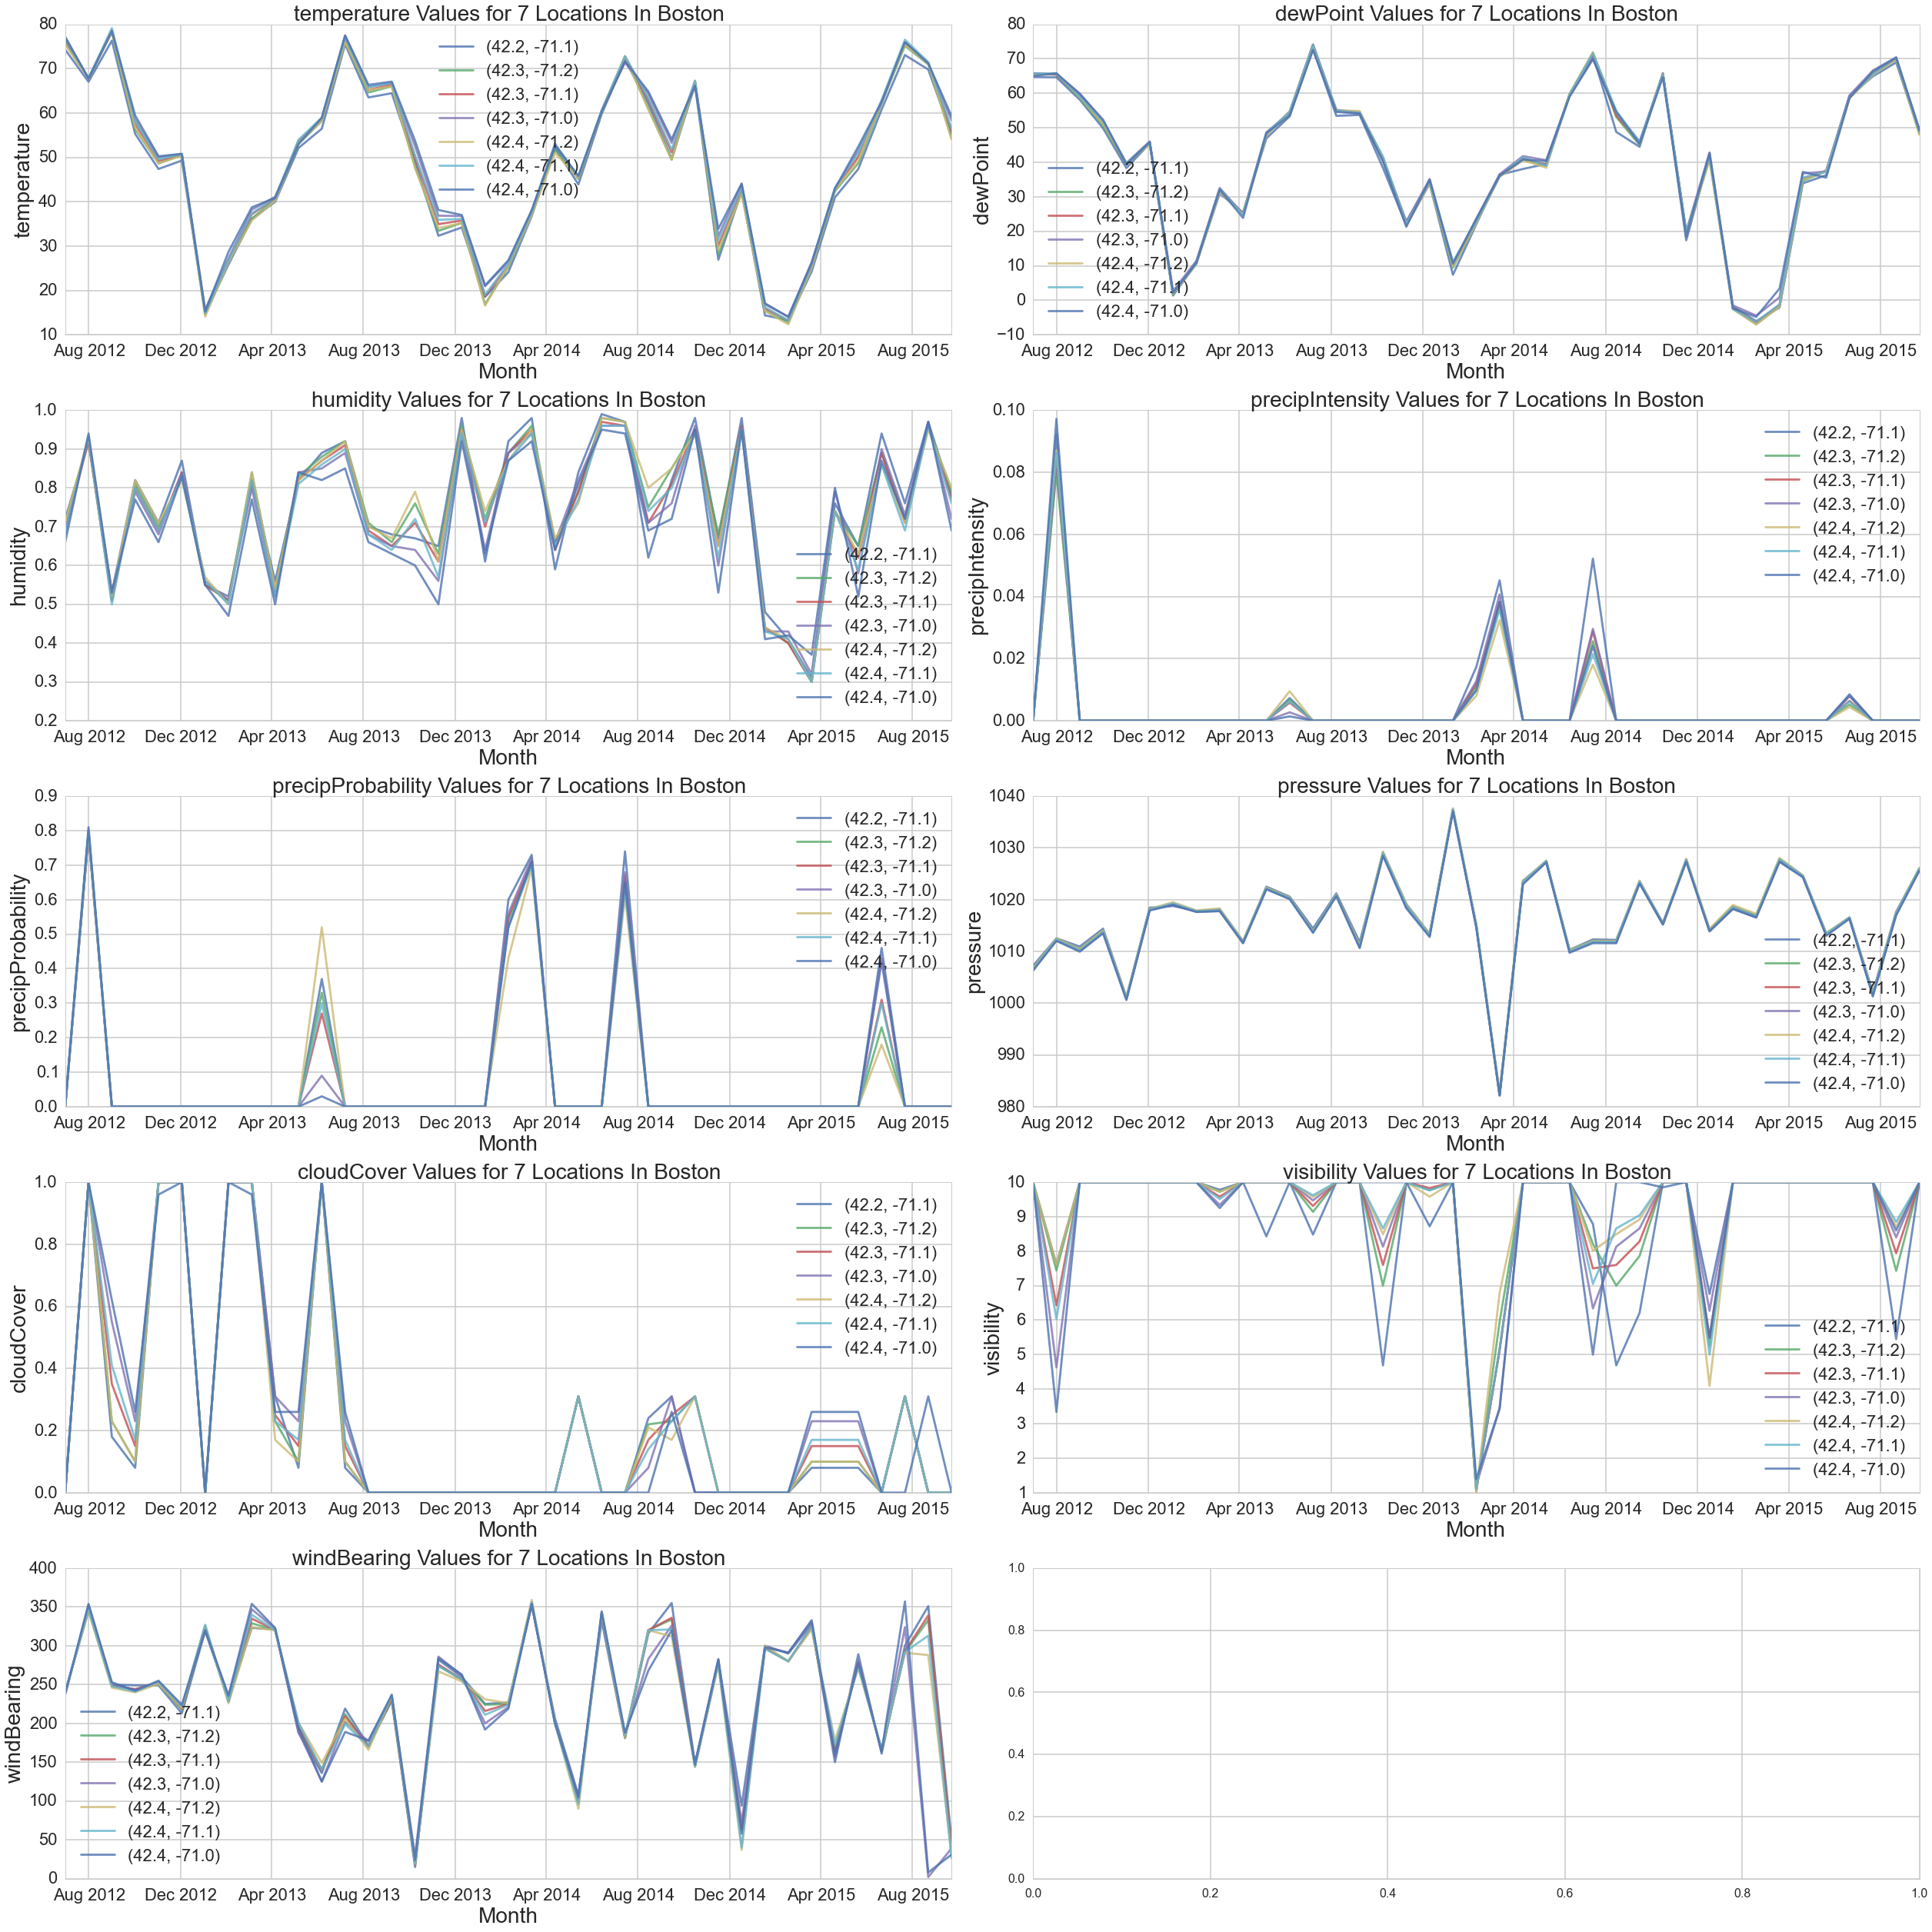

In [810]:
num_weather = ["temperature", "dewPoint", "humidity", "precipIntensity", "precipProbability", "pressure","cloudCover", "visibility", "windBearing"]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(35, 35), 
                         tight_layout=True)
for ax, n in zip(axes.ravel(), num_weather):
    for key, grp in df_weatherhourly.groupby(['LATITUDE', 'LONGITUDE']):
        key_label = "(%.1f, %.1f)" % (float(key[0]), float(key[1]))
        #plot only one value per month
        ax.plot(grp["DATETIME_TRUNC"][::24*31], grp[n][::24*31] ,label= key_label, alpha = .8)
        ax.set_title("%s Values for 7 Locations In Boston" %n, fontsize = 28)
        ax.set_ylabel("%s" %n, fontsize = 28)
        ax.set_xlabel("Month", fontsize = 28)
        ax.legend(loc='best', fontsize = 22) 
        ax.tick_params(labelsize = 22)

The graphs above clearly show the seasonal changes in each weather variables. Percipitation, for example, seems to be highest in January and Feburary then agian in July. In addition, visibility and (unsurprisingly) temperature seem to be lowest in the winter. The existence of seasonal variation in each of these factors is important for our modeling work later on. 

It is also clear from the graphs above that the weather is not exactly the same at each of these locations, even though they are all located within Boston. The variations may be a bit slight, but the seperation in the colored lines imlpy that they certainly exist. The graph of humidty above provides a good example of variation above. For a better understanding of the weather differences by location, we plot the mean values for each location in the bar charts below. Again, note that the bottom right graph is missing because we have only 9 columns (numerical weather variables) of interest:

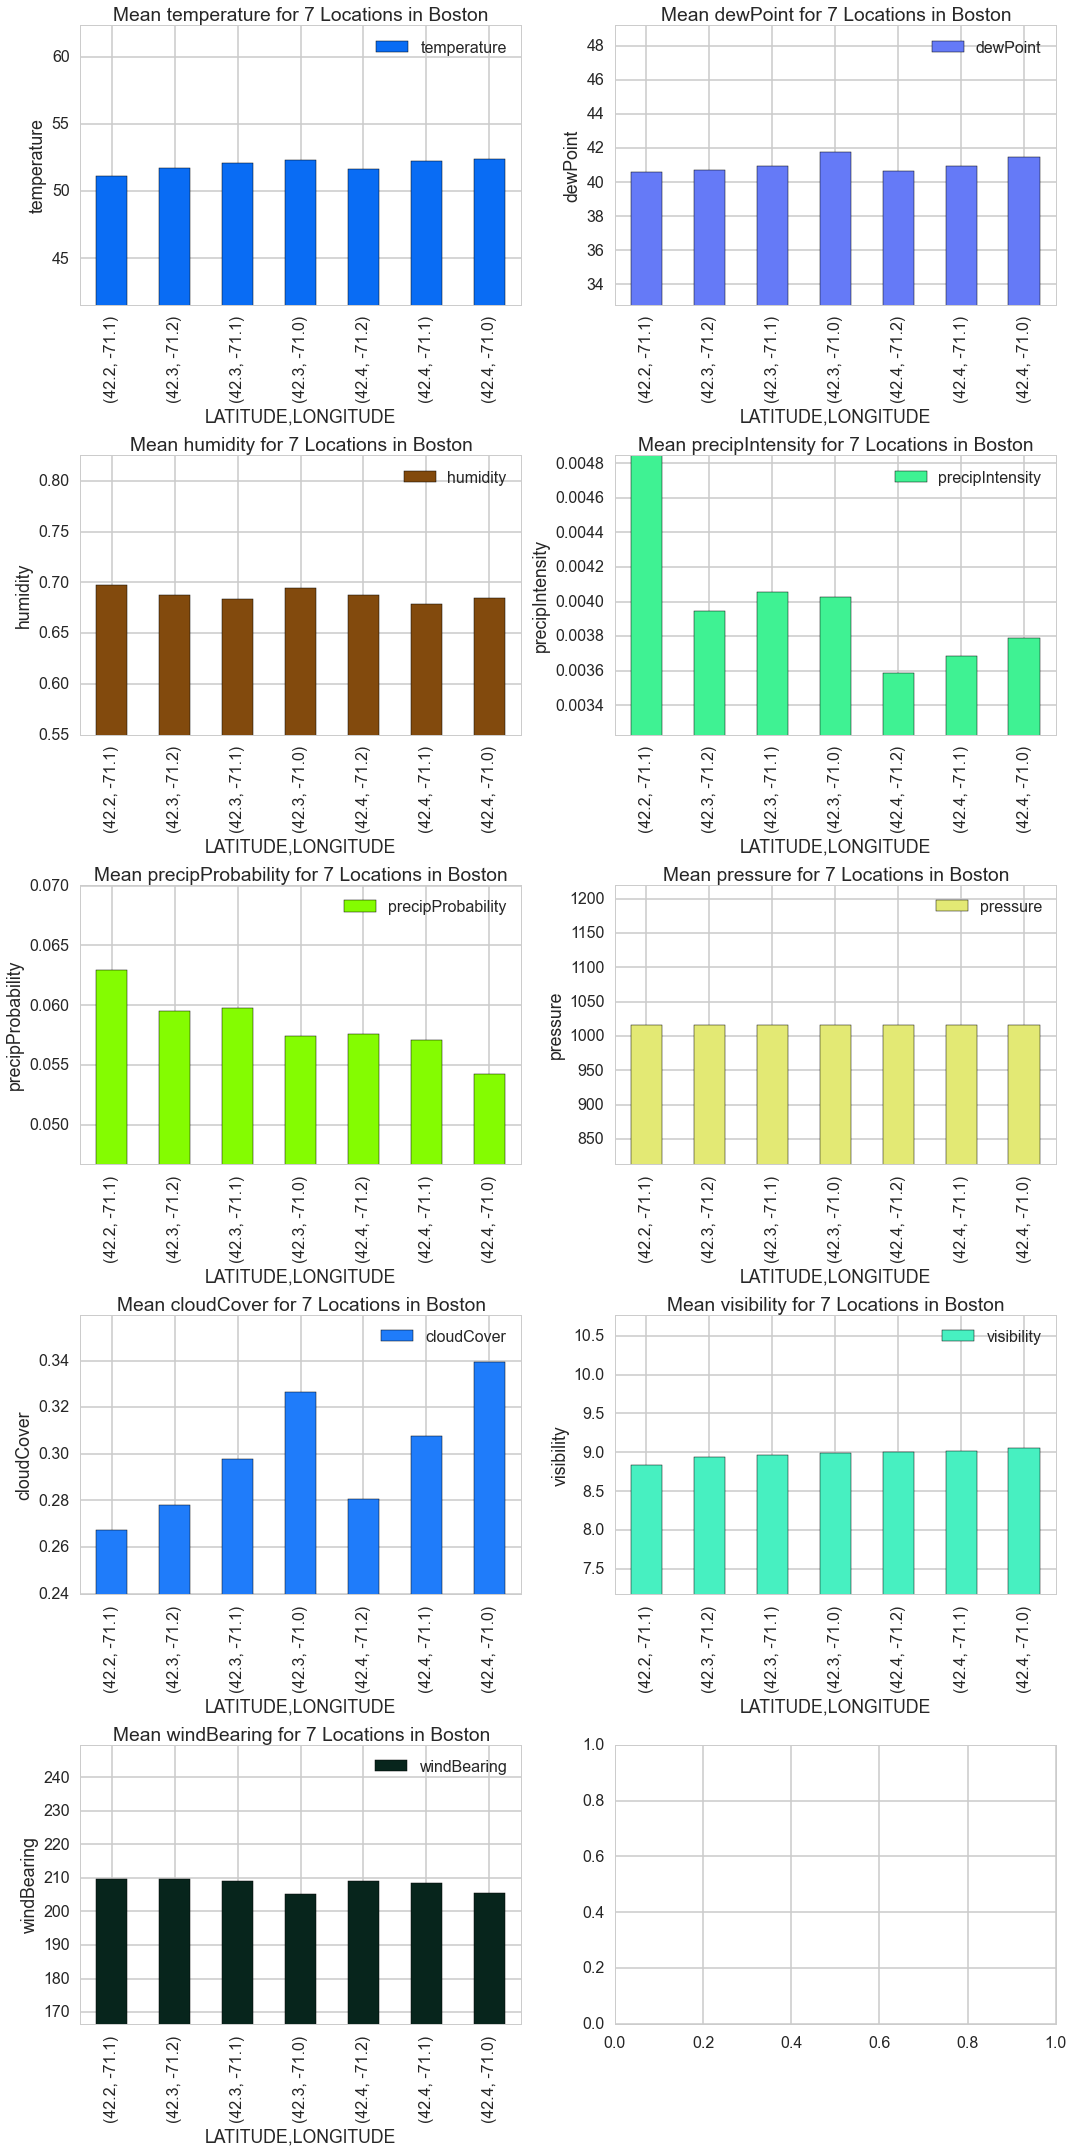

In [798]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 30), 
                         tight_layout=True)
for ax, n in zip(axes.ravel(), num_weather):
    mean_val = df_weatherhourly.groupby(['LATITUDE', 'LONGITUDE'])[n].mean().mean()
    df_weatherhourly.groupby(['LATITUDE', 'LONGITUDE'])[n].mean().plot(kind = "bar", label = n, ax = ax, color = np.random.rand(3,1))
    ax.set_ylabel("%s" %n)
    ax.set_ylim(.8*mean_val, 1.2*mean_val)
    ax.set_title("Mean %s for 7 Locations in Boston" %n)
    ax.legend(loc='best') 

Clearly, the weather does vary, on average, by location. Cloud coverage and percipitation seem to be the least consistent across locations.

# 3. Obtaining and Cleaning Dynamic Public School Closing Data

We now turn our attention to another type of dynamic data: public school closings. 

We essentially hope to use these closings as a proxy for how "free" the general population of boston is on a given day. For example, Saturdays and Sundays are categorized as the most "free" days because schools are closed and many adults are not working (in other words, offices are, for our purposes, considered closed). Holidays also fall into this category. Weekdays during the school year, on the other hand, are categorized as the least "free" days because children are occupied in school and adults are occupied at work (offices are open). 

Below we create a scale for classifying how "free" a given day is. The three possible values are 0, 1, and 2. The least "free" days (described above) are assigned a 0. The most "free" days (described above) are assigned a 2. Days assigned a value of 1 are those in which schools are closed but offices and businesses are largely operating as normal. These days include, but are not limited to, summer break, winter break, and snow days. 


Later, we hope to find a relationship between how "free" the population of boston is and the number of crimes that occur. Intuitively, it perhaps makes sense that more crimes would occur on days that are more "free." 

Our first step is creating a dataframe that stores the classification values of every day from July 2012:

In [689]:
import datetime
all_hours_school = []
epoch_school = []
#we start on June 30th instead of July 1 so our first day is a Saturday. This makes identifying weekends easier later on.
start = datetime.datetime(2012, 6, 30, 0)
for offset in range(0, 28488): 
    timeadd = start+datetime.timedelta(hours = offset)
    all_hours_school.append(timeadd)
    #also store the epoch value of the time to be used in later models
    epoch_school.append(timeadd.strftime('%s'))

We start by assigning every day a value of 0. We will go on to change the values for days that are meant to be classified as 1 or 2, but, because the majority of days will have a "free" value of 0 (see bar chart below), it is easiest to initialize every day with 0. Keep in mind that, throughout this process, we are classifying every hour of a given day so that our ending dataframe has hour granularity. 

In [690]:
#initialize every day as zero
listofzeros = [0]*len(all_hours_school)

The following calendars, made available by the Boston Public Schools, were used for accurate school closing information:

2012-2013: http://www.nctq.org/docs/Boston_cal_sy2013.pdf

2013-2014:http://bostonpublicschools.org/cms/lib07/MA01906464/Centricity/Domain/4/SY14%20calendar_markingperiods.pdf

2014-2015: http://www.bostonpublicschools.org/cms/lib07/MA01906464/Centricity/Domain/4/BPS%20CalMkPer%20SY15%20rev.pdf

2015-2016:http://www.bostonpublicschools.org/cms/lib07/MA01906464/Centricity/Domain/4/BPS%20CalMrkPer%20SY2016.pdf

We now classify all summer days, winter break days, and spring  break days with a "free" value of 1:

In [691]:
s2012_start = datetime.datetime(2012, 6, 30, 0, 0)
s2012_end = datetime.datetime(2012, 9, 6, 0, 0)
s2013_start = datetime.datetime(2013, 6, 21, 0, 0)
s2013_end = datetime.datetime(2013, 9, 4, 0, 0)
s2014_start = datetime.datetime(2014, 6, 24, 0, 0)
s2014_end= datetime.datetime(2014, 9, 4, 0, 0)
s2015_start= datetime.datetime(2015, 6, 29, 0, 0)
s2015_end= datetime.datetime(2015, 9, 8, 0, 0)
for hr in all_hours_school:
    #summer 2012
    if (hr >= s2012_start) & (hr < s2012_end):
        listofzeros[all_hours_school.index(hr)] = 1
    #summer 2013
    if (hr > s2013_start) & (hr < s2013_end):
        listofzeros[all_hours_school.index(hr)] = 1
    #summer 2014
    if (hr > s2014_start) & (hr < s2014_end):
        listofzeros[all_hours_school.index(hr)] = 1
    #summer 2015
    if (hr > s2015_start) & (hr < s2015_end):
        listofzeros[all_hours_school.index(hr)] = 1
    #Winter Break 2012
    if (hr >= datetime.datetime(2012, 12, 24, 0, 0)) & (hr < datetime.datetime(2013, 1, 3, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    #Winter Break 2013
    if (hr >= datetime.datetime(2013, 12, 23, 0, 0)) & (hr < datetime.datetime(2014, 1, 3, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    #Winter Break 2014
    if (hr >= datetime.datetime(2014, 12, 24, 0, 0)) & (hr < datetime.datetime(2015, 1, 3, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    #Spring Break 2012
    if (hr >= datetime.datetime(2013, 2, 19, 0, 0)) & (hr < datetime.datetime(2013, 2, 23, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    if (hr >= datetime.datetime(2013, 4, 16, 0, 0)) & (hr < datetime.datetime(2013, 4, 20, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    #Spring Break 2013
    if (hr >= datetime.datetime(2014, 2, 18, 0, 0)) & (hr < datetime.datetime(2014, 2, 22, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    if (hr >= datetime.datetime(2014, 4, 22, 0, 0)) & (hr < datetime.datetime(2014, 4, 26, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    #Spring Break 2014
    if (hr >= datetime.datetime(2015, 2, 17, 0, 0)) & (hr < datetime.datetime(2015, 2, 21, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
    if (hr >= datetime.datetime(2015, 4, 21, 0, 0)) & (hr < datetime.datetime(2015, 4, 25, 0, 0)):
        listofzeros[all_hours_school.index(hr)] = 1
#note WB2015 and SB2015 are not included because those dates occur later than Septemer 29th, 2015. 

We now identify all holidays and classify them with a "free" value of 2. To reiterate, we are actually classifying every hour of every day, but all hours in a given day have the same classification:

In [692]:
twentytwelveholidays = [datetime.datetime(2012, 10, 8, 0, 0), datetime.datetime(2012, 11, 12, 0, 0), datetime.datetime(2012, 11, 21, 0, 0),  datetime.datetime(2012, 12, 25, 0, 0),  datetime.datetime(2013, 1, 1, 0, 0), datetime.datetime(2013, 1, 21, 0, 0), datetime.datetime(2013, 2, 18, 0, 0), datetime.datetime(2013, 3, 18, 0, 0), datetime.datetime(2013, 3, 29, 0, 0), datetime.datetime(2013, 4, 15, 0, 0), datetime.datetime(2013, 5, 27, 0, 0), datetime.datetime(2013, 6, 17, 0, 0)]
twentythirteenholidays = [datetime.datetime(2013, 10, 14, 0, 0), datetime.datetime(2013, 11, 11, 0, 0), datetime.datetime(2013, 11, 27, 0, 0), datetime.datetime(2013, 12, 25, 0, 0),  datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2014, 1, 20, 0, 0), datetime.datetime(2014, 2, 17, 0, 0), datetime.datetime(2014, 3, 17, 0, 0), datetime.datetime(2014, 4, 18, 0, 0), datetime.datetime(2014, 4, 21, 0, 0), datetime.datetime(2014, 5, 26, 0, 0), datetime.datetime(2014, 6, 17, 0, 0)]
twentyfourteenholidays = [datetime.datetime(2014, 10, 13, 0, 0), datetime.datetime(2014, 11, 11, 0, 0), datetime.datetime(2014, 11, 26, 0, 0), datetime.datetime(2014, 12, 25, 0, 0),  datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2015, 1, 19, 0, 0), datetime.datetime(2015, 2, 16, 0, 0), datetime.datetime(2015, 4, 3, 0, 0), datetime.datetime(2015, 4, 20, 0, 0), datetime.datetime(2015, 5, 25, 0, 0)]
twentyfifteenholidays = [datetime.datetime(2015, 10, 12, 0, 0), datetime.datetime(2015, 11, 11, 0, 0), datetime.datetime(2015, 11, 25, 0, 0),  datetime.datetime(2015, 12, 25, 0, 0),  datetime.datetime(2016, 1, 1, 0, 0)]

allholidays = twentytwelveholidays + twentythirteenholidays + twentyfourteenholidays + twentyfifteenholidays 


In [693]:
#now let's do the holidays!
for hr in all_hours_school:
    for holiday in allholidays:  
        if (hr >= holiday) & (hr < holiday +datetime.timedelta(hours = 24)):
            listofzeros[all_hours_school.index(hr)] = 2

Next, we classify all snowdays with a "free" value of 1: 

In [799]:
#Note that, technically, Oct 29, 2012 was a hurricane day courtesy of Sandy.
twentytwelvesnowdays = [datetime.datetime(2012, 10, 29, 0, 0), datetime.datetime(2013, 2, 18, 0, 0)]
twentythirteensnowdays = [datetime.datetime(2014, 1, 3, 0, 0), datetime.datetime(2014, 1, 22, 0, 0)]
twentyfourteensnowdays = [datetime.datetime(2015, 1, 8, 0, 0), datetime.datetime(2015, 1, 27, 0, 0), datetime.datetime(2015, 1, 28, 0, 0), datetime.datetime(2015, 1, 29, 0, 0), datetime.datetime(2015, 2, 2, 0, 0), datetime.datetime(2015, 2, 3, 0, 0), datetime.datetime(2015, 2, 9, 0, 0), datetime.datetime(2015, 2, 10, 0, 0)]
twentyfifteensnowdays = []
allsnowdays = twentytwelvesnowdays + twentythirteensnowdays + twentyfourteensnowdays + twentyfifteensnowdays 


In [695]:
#snowday time!
for hr in all_hours_school:
    for snowday in allsnowdays:  
        if (hr >= snowday) & (hr < snowday +datetime.timedelta(hours = 24)):
            listofzeros[all_hours_school.index(hr)] = 1

Finally, we classify all weekends with a "free" value of 2. It is important to note that this overwrites previous classifications. For example, a weekend in the July will have been classified as a 1 above because school is not in session in the summer on weekdays and weekends. The code below changes this classification to a 2 because offices are also closed on the weekends in the summer.

In [696]:
#weekends start every 168 hours and last for 48 hours.
for index in range(0,len(listofzeros),168):
    for i in range(0, 47):
        listofzeros[index + i] = 2

We create a dataframe, called df_dayoff, that stores the classification of every hour (stored in datetime and in epoch):

In [739]:
df_dayoff = pd.DataFrame(zip(all_hours_school,epoch_school, listofzeros), columns = ["DATETIME_TRUNC", "EPOCH_TRUNC", "DAYOFF"])
df_dayoff.head()

,DATETIME_TRUNC,EPOCH_TRUNC,DAYOFF
0,2012-06-30 00:00:00,1341028800,2
1,2012-06-30 01:00:00,1341032400,2
2,2012-06-30 02:00:00,1341036000,2
3,2012-06-30 03:00:00,1341039600,2
4,2012-06-30 04:00:00,1341043200,2


In [741]:
#save the dataframe as a csv file for use in other portions of the project
df_dayoff.to_csv("JRschooldayoff.csv")

To better illustrate the our "free" classification scale that was used to create the values in df_dayoff, below we have created a color coded timeline for a particular month (April 5th 2013 to May 5th 2013):

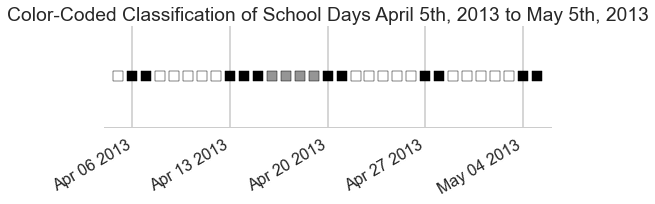

In [726]:
#this code is adapted from: http://stackoverflow.com/questions/32619424/is-it-possible-to-plot-timelines-with-matplotlib
#find the values for the month of interest
X = df_dayoff['DATETIME_TRUNC'][24*9*31:24*10*31][::24].values
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(X, [1]*len(X), c=df_dayoff['DAYOFF'][24*9*31:24*10*31][::24],
           marker='s', s=100)
fig.autofmt_xdate()

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Color-Coded Classification of School Days April 5th, 2013 to May 5th, 2013")

ax.get_yaxis().set_ticklabels([])
day = pd.to_timedelta("1", unit='D')
plt.xlim(X[0] - day, X[-1] + day)
plt.show()

White, grey, and black represent values of 0, 1, and 2, respectively. The white squares above represent days on which schools and offices were open. The Boston population was the least "free" on these days. The grey squares (April 16th, April 17th, April 18th, April 19th) represent a part of Spring Break (appropriately named "April Recess") for public schools. Therefore, schools were closed but offices were open and operating as normal. Black squares represent weekends as well as one holiday (Monday, April 15--Patriot's Day), days on which both schools and offices were, generally, closed. The Boston population is the most "free" on these days.

Hopefully this color coded timeline clears up any potential confusion regarding the classification system used in this section. For further understanding of our school closing dataset (df_dayoff), we plot the total number of days classified as each of the three "free" values. Note that we are not counting total number of hours, even though our dataset has hour granularity. We can count days instead of hours because, as mentioned above, every hour in a given day has the same "free" value:

Total number of days between 6/30/12 and 9/29/15 labeled 0: 560
Total number of days between 6/30/12 and 9/29/15 labeled 1: 260
Total number of days between 6/30/12 and 9/29/15 labeled 2: 365


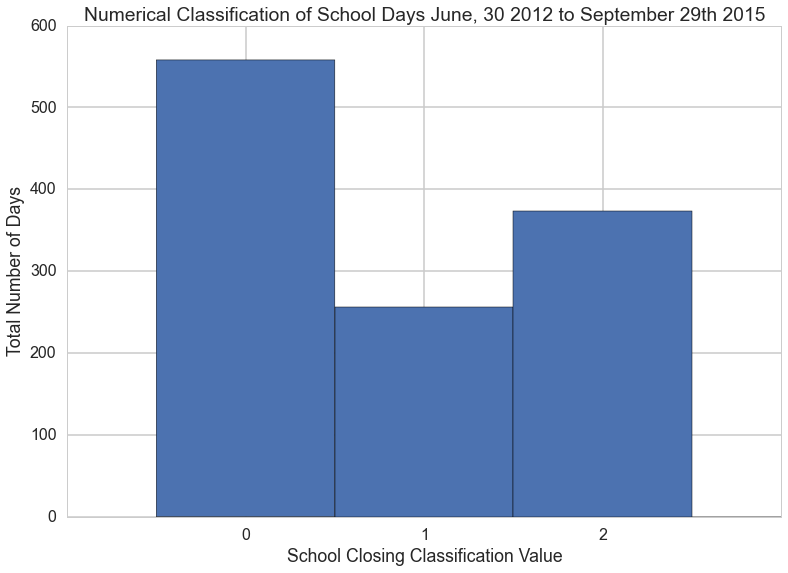

In [800]:
print "Total number of days between 6/30/12 and 9/29/15 labeled 0:", len(df_dayoff[df_dayoff['DAYOFF'] == 0].values)/24
print "Total number of days between 6/30/12 and 9/29/15 labeled 1:" , len(df_dayoff[df_dayoff['DAYOFF'] == 1].values)/24
print "Total number of days between 6/30/12 and 9/29/15 labeled 2:" , len(df_dayoff[df_dayoff['DAYOFF'] == 2].values)/24
#plot every day rather than every hour
plt.hist(df_dayoff['DAYOFF'][::24].values, bins=np.arange(50)-0.5, normed=False)
plt.xticks(np.arange(0,2.01,1))
plt.xlim(-1,3)
plt.title("Numerical Classification of School Days June, 30 2012 to September 29th 2015")
plt.ylabel("Total Number of Days")
plt.xlabel("School Closing Classification Value")



Perhaps unsurprisingly, the most common classification for a day between June, 30 2012 and September 29, 2015 was 0. This implies that, for the majority of days, schools and offices are open as usual.  The second most common classification value was 2, days on which everything is closed. The least common "free" value assigned was 1, given, for example, to weekdays during the summer,  weekdays during winter break, and snow days. 

# 4. Obtaining and Cleaning Dynamic Unemployment Rate Data

We now turn to another dynamic factor: the unemployment rate. We use unemployment rate as a proxy for the overall economic state of Boston for the months between July 2012 and August 2015. We hope to understand the relationship between economic state and criminal activity. First, we read in a dataset that contains the monthly unemployment rate for Boston:

In [703]:
urate_df=pd.read_csv("BostonURATE.csv")

To match the format of previous datasets, we must report these unemployment rates by the hour. Note that the specific location is not important in this case because the unemployment rates are for all of Boston and therefore apply to all latitude and longitude pairs in the weather conditions dataset. We start, then, by creating a list of all hours for which we need an unemployment rate figure:

In [704]:
import datetime
all_hours_urate = []
epoch_urate = []
start = datetime.datetime(2012, 7, 1, 0)
for offset in range(0, 28488): 
    timeadd_u = start+datetime.timedelta(hours = offset)
    all_hours_urate.append(timeadd_u)
    epoch_urate.append(timeadd_u.strftime('%s'))
    

In [705]:
#This cleans the initial dataset by removing the 1/2012 through 6/2012. This is necessary because our crime dataset begin in 7/2012
urate_dfclean = urate_df.ix[6:]
#2012
urate2012df = urate_dfclean.iloc[0:6]
#2013
urate2013df = urate_dfclean.iloc[6:18]
#2014
urate2014df = urate_dfclean.iloc[18:30]
#2015
urate2015df = urate_dfclean.iloc[30:]


The unemployment rate is assumed to be the same for every hour of a given month. The following, then, assigns the appropriate values for each hour then creates a dataframe (named urate_hourdf) to display this data:

In [759]:
import datetime

urate_hour = []
for i, r in urate_dfclean.iterrows():
    #the range values match the number of hours in that month
    if r["MONTH"].startswith( '1/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])
    if r["MONTH"].startswith( '2/' ):
         urate_hour.extend([r["URATE"] for ur in range(672)])
    if r["MONTH"].startswith( '3/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])
    if r["MONTH"].startswith( '4/' ):
        urate_hour.extend([r["URATE"] for ur in range(720)])
    if r["MONTH"].startswith( '5/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])
    if r["MONTH"].startswith( '6/' ):
        urate_hour.extend([r["URATE"] for ur in range(720)])
    if r["MONTH"].startswith( '7/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])
    if r["MONTH"].startswith( '8/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])
    if r["MONTH"].startswith( '9/' ):
        urate_hour.extend([r["URATE"] for ur in range(720)])
    if r["MONTH"].startswith( '10/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])
    if r["MONTH"].startswith( '11/' ):
        urate_hour.extend([r["URATE"] for ur in range(720)])
    if r["MONTH"].startswith( '12/' ):
        urate_hour.extend([r["URATE"] for ur in range(744)])


In [760]:
urate_hourdf = pd.DataFrame(zip(all_hours_urate, epoch_urate, urate_hour), columns = ["DATETIME_TRUNC","EPOCH_TRUNC", "URATE"])
urate_hourdf.head()

,DATETIME_TRUNC,EPOCH_TRUNC,URATE
0,2012-07-01 00:00:00,1341115200,6.4
1,2012-07-01 01:00:00,1341118800,6.4
2,2012-07-01 02:00:00,1341122400,6.4
3,2012-07-01 03:00:00,1341126000,6.4
4,2012-07-01 04:00:00,1341129600,6.4


We save this dataset as a csv to be used elsewhere:

In [710]:
urate_hourdf.to_csv("JRhourlyurate.csv")

We graph the Boston unemployment rate from July 2012 to August 2015:

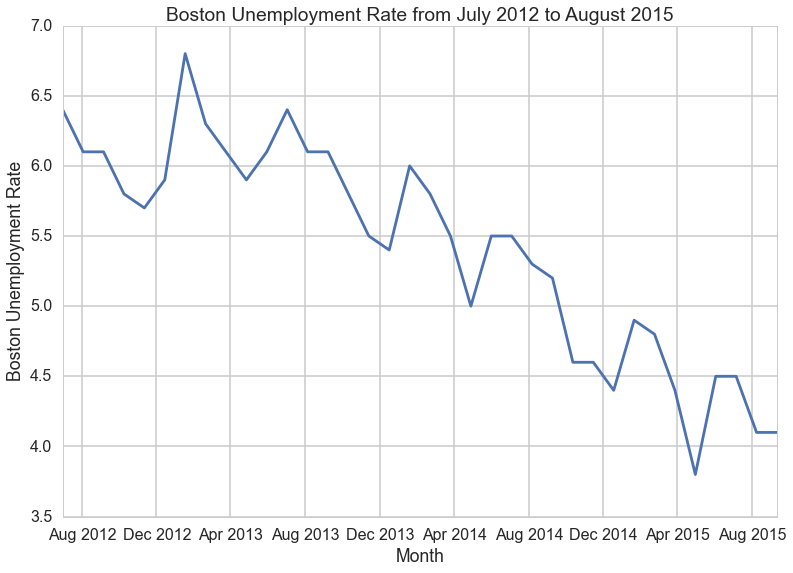

In [711]:
plt.plot(urate_hourdf["DATETIME_TRUNC"][::800], urate_hourdf["URATE"][::800])
plt.title("Boston Unemployment Rate from July 2012 to August 2015")
plt.xlabel("Month")
plt.ylabel("Boston Unemployment Rate")

Clearly, the unemployment rate has been fairly steadily declining over our time interval. 

# 5. Dynamic Event Data

We now focus our attention on obtaining the last dynamic data set: events. We essentially hope to determine how many events (i.e. sports games, concerts, shows) are occuring near a particlar location at a given time. However, as is evident in the dynamic modeling section of this project, the event data gathered below is not ultimately used. The reason for this exclusion is, primarily, the lack of access to historical data.

**The inability to query data for all days from 2012 to 2015 proved to seriously limit our ability to find and use a plethora of dynamic sources.** For example, every traffic API only permitted access to real-time traffic information. The Twitter API provided only tweets that were less than 30 years old, and the Facebook API provided public events that were currently ongoing or scheduled for the future. 

Similarly, both the SeatGeek and Eventful APIs did not allow us to access data about events in our desired time range. The SeatGeek API provided information about only active listings (events going on today and any day in the future). The Eventful API provided historical data as far back as January 2014 but has really only been seriously used as an events platform in 2015. For example, as shown below, Eventful lists that only 9 events took place at (42.4, -72.1) on April 22, 2014 but lists that 1506 events took place at that same location exactly one year later on April 22, 2015. This annual mismatch is prominent throughout the Eventful data. 

Clearly, the datasets acquired from the SeatGeek and Eventful APIs are not fit for use in our models. However, to make this judgement call, we had to obtain and make sense of the information from the sources. Below we start by showing our work with the Eventful API: 

In [97]:
!pip install eventful

First, we must format our 7 lat-long pairs of interest differently to match the Eventful API requirements:

In [742]:
#these are the same 7 lat-long pairs used above, but are formatted differently because of the requirements of the eventful API.
eventful_ll = []
for ll in all_two_unique:
    eventful_ll.append(str(ll).replace('(', '').replace(')', ''))


Because, as mentioned above, the oldest information acessible with Eventful API dates January 2014, we only need to examine hours from Juanary 2014:

In [243]:
import datetime
all_dates_eventful = []
start = datetime.datetime(2014, 1, 1)
for offset in range(0, 650): 
    all_dates_eventful.append(start+datetime.timedelta(offset))
    

We now query the Eventful API. For every lat-long pair, we find the number of events that have a start time of a given day and occur within 10 miles of the location specified by the latitude and longitude. Because Eventful provides daily event totals but our previous datasets have hour granularity, we simply list the same event total for every hour of a given day. Note that this code takes a bit of time to run, approximately 15 minutes on my machine:

In [311]:
%%time
#this API usage is adapted from here: https://api.eventful.com/libs/python/
import eventful
import datetime
api = eventful.API('4FjkqSv458wvxk53')

attributes = ["DATETIME_TRUNC" , 'LATITUDE' , "LONGITUDE", "EVENTFUL"]
eventful_data = {}
for attr in attributes:
    eventful_data[attr] = []


for today in all_dates_eventful:
    tomorrow = today + datetime.timedelta(hours=24)
    day_str = today.strftime('%Y%m%d00')
    tomorrow_str = tomorrow.strftime('%Y%m%d00')
    day_range = "%s-%s" %(day_str, tomorrow_str)
    for ll in eventful_ll:
        lat = ll[:4]
        lon = ll[6:]
        events = api.call('/events/search', l=ll , within = '10', date = day_range, page_size = '1')
        total = events['total_items']
        #assign every hour in a given day the same lat, long, and total
        eventful_data["LATITUDE"].extend([float(lat) for x in range(24)])
        eventful_data["LONGITUDE"].extend([float(lon) for x in range(24)])
        #use these for dataset that is daily. use other extend commands for dataset that is hourly.
        #eventful_data['LATITUDE'].append(float(lat))
        #eventful_data["LONGITUDE"].append(float(lon))
        #eventful_data["DATETIME_TRUNC"].append(today)
        #eventful_data["EVENTFUL"].append(total)
        for i in range(0,24):
            eventful_data["DATETIME_TRUNC"].append(today + datetime.timedelta(hours=i))
        eventful_data["EVENTFUL"].extend([total for x in range(24)])


CPU times: user 6.98 s, sys: 1.82 s, total: 8.8 s
Wall time: 16min 20s


We store this Eventful information in df_eventful. As an example of the information we obtained, we also report the event totals for a particular location on a particular date as well as the event totals for that same location exactly one year later. As mentioned above, there are far more events listed in 2015 than in 2014, a trend that holds for many other days than just the one shown here. This imbalance is yet another reason why we did not end up using the Eventful data in our models.

In [782]:
df_eventful = pd.DataFrame(eventful_data, index=eventful_data['DATETIME_TRUNC'])
#event totals for location (42.4, -71.2) on April 22, 2014.
df_eventful.iloc[18680:18685]

,DATETIME_TRUNC,EVENTFUL,LATITUDE,LONGITUDE
2014-04-22 08:00:00,2014-04-22 08:00:00,8,42.4,-71.2
2014-04-22 09:00:00,2014-04-22 09:00:00,8,42.4,-71.2
2014-04-22 10:00:00,2014-04-22 10:00:00,8,42.4,-71.2
2014-04-22 11:00:00,2014-04-22 11:00:00,8,42.4,-71.2
2014-04-22 12:00:00,2014-04-22 12:00:00,8,42.4,-71.2


In [783]:
#event totals for location (42.4, -71.2) exactly one year later on April 22, 2015.
df_eventful.iloc[80000:80005]

,DATETIME_TRUNC,EVENTFUL,LATITUDE,LONGITUDE
2015-04-22 08:00:00,2015-04-22 08:00:00,1506,42.4,-71.2
2015-04-22 09:00:00,2015-04-22 09:00:00,1506,42.4,-71.2
2015-04-22 10:00:00,2015-04-22 10:00:00,1506,42.4,-71.2
2015-04-22 11:00:00,2015-04-22 11:00:00,1506,42.4,-71.2
2015-04-22 12:00:00,2015-04-22 12:00:00,1506,42.4,-71.2


In [784]:
#Store this Eventful data 
df_eventful.to_csv("JReventful.csv", index=True)

Finally, we turn our attention to the SeatGeek API. As previously mentioned, the data from SeatGeek was not used in our models because it does not provide any access to historical data. That being said, we include it here because it exemplifies a part of an important possible future extension of our project. 

Our work throughout these ipython notebooks attempts to determine, based upon a variety of features, whether a crime will or has occured in a given time and place. We use historical data from 2012 to 2015 to train and test our models. We hope that our models would assist police deparments in determining where to deploy officers and other resources. To be truly useful in the future, then, our models cannot simply rely on historical data from 2012 to 2015; we must incorporate real-time information. Below, we use the SeatGeek API to show an example of how this real-time information can be gathered.

Because granular location is more important for events than it is for weather, we should use lat-long pairs reported up to two decimal places rather than one. So, we start by gathering these unique lat-long pairs:

In [787]:
all_two2 = []
for i, r in time_df.iterrows():
    lat = float('%.2f'%(r["LATITUDE"]))
    long = float('%.2f'%(r["LONGITUDE"]))
    all_two2.append((lat,long))
   

In [791]:
all_two2_unique = set(all_two2)
print "total number of not unique lat-long pairs (to 2 decimal places) in dataset:" , len(all_two2)
print "total number of unique lat-long pairs (to 2 decimal places) in dataset:", len(all_two2_unique)
print "difference:" , len(all_two3) - len(all_two2_unique)

total number of not unique lat-long pairs (to 2 decimal places) in dataset: 253075
total number of unique lat-long pairs (to 2 decimal places) in dataset: 172
difference: 252903


172 unique pairs is far greater than the 7 unique pairs we used when only concerned with one decimal place. If we were to use the 172 unique pairs to gather hourly historical data, we would end up with a very large dataset. 

Because we are interested in obtaining only real-time dynamic data, the following code uses the SeatGeek API to find the number of events within 5 miles of a given location that start no more than three hours before the current time or no more than three hours after the current time. The current time is determined by the time at which the API call is made. In addition to the total number of events, we also included a list that stores the type of each event. A tuple of the total number and the list of types is stored in the SG column of the df_SG dataframe below.

In [801]:
%%time
#code adapted from: http://www.burakbekdemir.com/2012/05/26/seatgeek-api-with-python/
import httplib
import json
from pprint import pprint
#use pprint(json_data) below if you want to see the json data created
from datetime import date
import datetime
#from datetime import datetime

attributes = ["DATETIME" , 'LATITUDE' , "LONGITUDE", "SG"]
sg_data = {}
for attr in attributes:
    sg_data[attr] = []
#change to all_two_unique for dataset of lat-long values to one decimal place
for ll in all_two2_unique:
    lat = str(ll[0])
    lon = str(ll[1])
    range1 = str(5)
    #get current time now
    datetimenow = datetime.datetime.now()
    #find the times 3 hours before and 3 hours after the current time to set the query range
    datetime15 = datetimenow.strftime('%Y-%m-%d %H:%M:%S.%f')
    datetime15 = datetime15[:-7]
    datetime2= datetime.datetime.strptime(datetime15, '%Y-%m-%d %H:%M:%S')
    datetime25 =  datetime2 - datetime.timedelta(hours=3)
    datetime3 = str(datetime25.strftime('%Y-%m-%dT%H:%M:%S'))
    datetime4 = (datetime2 + datetime.timedelta(hours=3)).strftime('%Y-%m-%dT%H:%M:%S')
    #query with all relevant information
    query = '/2/events?lat='+lat+'&lon='+lon+'&range='+range1+'mi&datetime_local.gte='+datetime3+'&datetime_local.lte='+datetime4+'&per_page=100'
    root_url = "api.seatgeek.com"
    conn = httplib.HTTPConnection(root_url)
    conn.request("GET", query)
    response = conn.getresponse()
    data = response.read()
    json_data = json.loads(data)
    type_list = []
    for i in json_data["events"]:
        type_list.append(i['type'])
    sg_data['LATITUDE'].append(lat)
    sg_data["LONGITUDE"].append(lon)
    sg_data["DATETIME"].append(datetime15)
    sg_data["SG"].append((json_data["meta"]['total'], type_list))


CPU times: user 973 ms, sys: 353 ms, total: 1.33 s
Wall time: 23.9 s


As before, we create a database with hour granularity that holds the SeatGeek information:

In [802]:
df_sg = pd.DataFrame(sg_data, index=sg_data['DATETIME'])
df_sg.head()

,DATETIME,LATITUDE,LONGITUDE,SG
2015-12-05 18:30:04,2015-12-05 18:30:04,42.33,-71.04,"(22, [family, ncaa_hockey, concert, theater, c..."
2015-12-05 18:30:05,2015-12-05 18:30:05,42.35,-71.13,"(27, [family, ncaa_hockey, concert, theater, c..."
2015-12-05 18:30:05,2015-12-05 18:30:05,42.34,-71.14,"(27, [family, ncaa_hockey, concert, theater, c..."
2015-12-05 18:30:05,2015-12-05 18:30:05,42.26,-71.13,"(1, [concert])"
2015-12-05 18:30:05,2015-12-05 18:30:05,42.33,-71.02,"(15, [family, concert, theater, concert, theat..."


**In summary...**

This ipython notebook completes, including but not limited to, the following: 

- Further cleans our crime incident dataset. More cleaning is completed in a different notebook. 
- Obtains, cleans, compiles, and organizes the following dynamic sources into datasets sorted by location and hour: weather, unemployment rates, and school closings. 
- Discusses the use of dynamic event data, the difficulties inherent in requiring historical data, and the future importance of real-time data. Obtains datasets from two sources that are not ultimately used in the dynamic models.